In [ ]:
# process abdb dataset

In [2]:
# import stuff
import find_files
import numpy as np
import sys
import seaborn as sns
from matplotlib import pyplot as plt
import os
import pandas as pd

# set general style for plots
sns.set(style='ticks', palette = 'pastel')

In [ ]:
def view_temp():
	'''
	View temporary plot
	'''
	sns.despine()
	temppdf = 'abdb_figures/temp.pdf'
	plt.savefig(temppdf)
	os.system('open %s' % temppdf)

In [ ]:
def get_single_antigens():
	'''
	Get files with single antigen
	'''
	file_paths = find_files.find_files('../datasets','.pdb')
	seqres_index = []
	singles = []
	for fp in file_paths:
		contents = open(fp).read().splitlines()
		for i, line in enumerate(contents):
			if line.startswith('SEQRES'):
				seqres_index.append(i)
				if i <= 16:
					singles.append(fp)
				break
	#splits = []
	#for s in singles:
	#	s = len(open(s).read().split('TER  '))
	#	splits.append(s)
	#print(set(splits))
	return singles

In [ ]:
def get_residue_pairs():
	'''
	Gets antibody-antigen residue pairs according to some distance d.
	Considers only CA atoms.
	'''
	file_paths = get_single_antigens()
	top15s = 'distance,agresname,agchain,agresnum,abresname,abchain,abresnum,name\n' 
	for fp in file_paths[:]:
		parts = open(fp).read().split('TER  ')
		antigen = parts[-2]
		antigen = [line for line in antigen.split('\n') if 'CA' in line[12:16] and line.startswith('ATOM')]
		antibody = parts[0] + parts[1]
		antibody = [line for line in antibody.split('\n') if 'CA' in line[12:16] and line.startswith('ATOM')]
		min_pairs = []
		sample_name = fp.split('/')[-1].split('.')[0]
		for ag in antigen:
			min_pair = [] # nearest pair
			ag_c = np.array([ag[30:38], ag[38:46], ag[46:54]], dtype='float16')
			ag_inf = [ag[17:20], ag[21], ag[22:26]]
			min_d = 1000
			for ab in antibody:
				ab_c = np.array([ab[30:38], ab[38:46], ab[46:54]], dtype='float16')
				d = np.sqrt(np.sum((ag_c-ab_c)**2))
				if d < min_d:
					min_d = [d]
					ab_inf = [ab[17:20], ab[21], ab[22:26]]
					min_pair = [d] + ag_inf + ab_inf + [sample_name]
			min_pairs.append(min_pair)
		top15 = sorted(sorted(min_pairs)[:15], key = lambda item: item[3])
		joined = ''
		for t in top15:
			t = ','.join([str(item).strip() for item in t]) + '\n'
			joined += t
		#joined += 'TER\n'
		top15s += joined
	outpath = 'abdb_outfiles/respair.csv'
	outfile = open(outpath, 'w')
	outfile.write(top15s)
	outfile.close()

In [ ]:
def get_residue_pairs_ab():
	'''
	Gets antibody-antigen residue pairs according to some distance d.
	Considers only CA atoms.
	iterates over antibodies
	'''
	file_paths = get_single_antigens()
	top15s = 'distance,abresname,abchain,abresnum,agresname,agchain,agresnum,name\n' 
	for fp in file_paths[:]:
		parts = open(fp).read().split('TER  ')
		antigen = parts[-2]
		antigen = [line for line in antigen.split('\n') if 'CA' in line[12:16] and line.startswith('ATOM')]
		antibody = parts[0] + parts[1]
		antibody = [line for line in antibody.split('\n') if 'CA' in line[12:16] and line.startswith('ATOM')]
		min_pairs = []
		sample_name = fp.split('/')[-1].split('.')[0]
		for ag in antibody: #use antibody here
			min_pair = [] # nearest pair
			ag_c = np.array([ag[30:38], ag[38:46], ag[46:54]], dtype='float16')
			ag_inf = [ag[17:20], ag[21], ag[22:26]]
			min_d = 1000
			for ab in antigen: # use antigen here
				ab_c = np.array([ab[30:38], ab[38:46], ab[46:54]], dtype='float16')
				d = np.sqrt(np.sum((ag_c-ab_c)**2))
				if d < min_d:
					min_d = [d]
					ab_inf = [ab[17:20], ab[21], ab[22:26]]
					min_pair = [d] + ag_inf + ab_inf + [sample_name]
			min_pairs.append(min_pair)
		top15 = sorted(sorted(min_pairs)[:15], key = lambda item: item[3])
		joined = ''
		for t in top15:
			t = ','.join([str(item).strip() for item in t]) + '\n'
			joined += t
		#joined += 'TER\n'
		top15s += joined
	outpath = 'abdb_outfiles/respair_ab_top15.csv'
	outfile = open(outpath, 'w')
	outfile.write(top15s)
	outfile.close()

In [ ]:
def lh_counts():
	'''
	Checks light and heavy chain counts
	'''
	samples = open('abdb_outfiles/respair.csv').read().split('TER')
	H = 0
	L = 0
	for i, sample in enumerate(samples):
		residues = sample.split()
		for r in residues:
			r = r.split(',')
			if r[5] == 'H':
				H += 1
			elif r[5] == 'L':
				L += 1
	hfrac = float(H)/sum([H,L])
	lfrac = float(L)/sum([H,L])
	x = ['H', 'L']
	y = [H,L]
	sns.barplot(x,y)
	plt.title('Residues in heavy and light chains')
	plt.xlabel('Chain')
	plt.ylabel('Count')
	filename = 'abdb_figures/hl.pdf'
	plt.savefig(filename)
	os.system('open %s' % filename)
	#print(help(sns.barplot))	
	return H, L

In [ ]:
def respair_exams(filepath):
	'''
	Examines respair.csv
	obs: 1/3 of epitope residues are in the light chain.
		   spatial distance is between 3-10 angstrom.
	'''
	filename = filepath.split('/')[-1].split('.')[0]
	dataset = pd.read_csv(filepath)
	sns.set(style='ticks', palette='BuGn')
	sns.catplot(x='abchain', kind='count', data=dataset)
	outname = 'abdb_figures/%s_abchain_count.pdf' % filename
	plt.savefig(outname)
	os.system('open %s' % outname)
	outname2 = 'abdb_figures/%s_abchain_distance.pdf' % filename
	sns.catplot(x='abchain',y='distance', kind='box', data=dataset)
	plt.savefig(outname2)
	os.system('open %s' % outname2)
	
	

In [ ]:
def positional_distance(filepath):
	'''
	Plots distance between positions
	'''
	filename = filepath.split('/')[-1].split('.')[0]
	#infile = 'abdb_outfiles/respair.csv'
	df = pd.read_csv(filepath)
	name_distance = df.xs(['name','agresnum','abresnum'],axis=1).values
	resnum_diffs = []
	for i in range(len(name_distance)-1):
		if name_distance[i,0] == name_distance[i+1,0]:
			diff = np.abs(name_distance[i,1:] - name_distance[i+1,1:])
			if diff[0] < 15:
				resnum_diffs.append(diff)
	resnum_diffs = pd.DataFrame(resnum_diffs, columns=['agdist','abdist'])
	#sns.set(style='ticks', palette = 'BuGn_d')
	sns.jointplot(x='agdist', y='abdist', data=resnum_diffs, kind='kde')
	#outname = 'abdb_figures/%s_agdist_abdist.pdf' % filename
	#plt.savefig(outname)
	#os.system('open %s' % outname)
	#print(help(df))

In [ ]:
def get_h_epitope():
	'''
	Filters respair.csv for heavy chain epitopes. 
	'''
	df = pd.read_csv('abdb_outfiles/respair.csv')
	#print(dir(df))
	filepath = 'abdb_outfiles/respair_h.csv'
	newvalues=  []
	df.to_csv(filepath)
	for line in df.values:
		if line[5]  == 'H':
			newvalues.append(line)
	newdf = pd.DataFrame(newvalues, columns=df.columns.values)
	newdf.to_csv(filepath, index=False)
	#plt.show()

In [ ]:
def get_h_epitope_ab():
	'''
	Filters respair.csv for heavy chain epitopes. 
	'''
	df = pd.read_csv('abdb_outfiles/respair_ab_full.csv')
	#print(dir(df))
	filepath = 'abdb_outfiles/respair_ab_full_h.csv'
	newvalues=  []
	df.to_csv(filepath)
	for line in df.values:
		if line[2]  == 'H':
			newvalues.append(line)
	newdf = pd.DataFrame(newvalues, columns=df.columns.values)
	newdf.to_csv(filepath, index=False)
	#plt.show()

In [ ]:
def get_seq_pair():
	'''
	Gets antibody-antigen sequence pairs
	'''
	infile = 'abdb_outfiles/respair_ab_full_h.csv'
	df = pd.read_csv(infile)	
	aafile = '../datasets/amino_acids/the_twenty.txt'
	aacontent = open(aafile).read().splitlines()
	aadict = dict((item.split()[1].upper(),item.split()[-1]) for item in aacontent)
	seqs = []
	samples = {}
	values = df.values
	for val in values:
		name = val[-1]
		agres = val[1]
		abres = val[4]
		print(val)
		if name not in samples:
			samples[name] = [aadict[agres], aadict[abres]]
		elif name in samples:
			samples[name][0] += aadict[agres]
			samples[name][1] += aadict[abres]
	#print(samples.items())
	todf = [[key] + val for key, val in samples.items()]
	newdf = pd.DataFrame(todf, columns=['name','abseq','agseq'])
	outfile = infile.split('.')[0] + '_seqpair.' + infile.split('.')[-1]
	newdf.to_csv(outfile, index=False)
	#print(help(pd.DataFrame))

{'CAF', 'CAV', 'CAT', 'CAH', 'CAA', 'CAK', 'CAL', 'CAN', 'CAQ', 'CAY', 'CAM', 'CAS', 'CAG', 'CAI'}
690 690


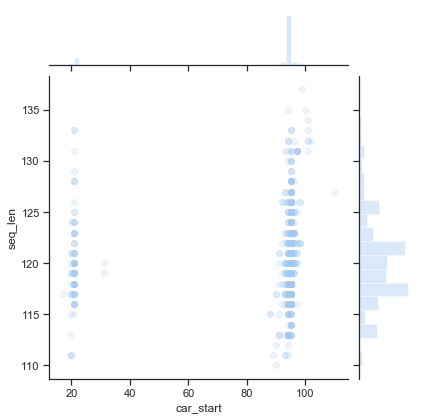

In [31]:
def find_car():
	'''
	Finds CAR segment on a sequence
	'''
	infile = 'abdb_outfiles/respair_ab_full_h_seqpair.csv'
	df = pd.read_csv(infile)
	rnums = [] # CAR start position
	len_cars = [] # length of seq
	variants = [] # CAR variants
	i_cars = []
	for i,row in df.iterrows():
		n = len(row.abseq)
		for rnum in range(n-2):
			triplet = row.abseq[rnum:rnum+3]
			if triplet == 'CAR' and i not in i_cars:
				rnums.append(rnum)
				len_cars.append(n)
				i_cars.append(i)
	for i, row in df.iterrows():
		if i not in i_cars:
			n = len(row.abseq)
			for rnum in range(n-2):
				triplet = row.abseq[rnum:rnum+3]
				if triplet.startswith('CA'):
					rnums.append(rnum)
					len_cars.append(n)
					i_cars.append(i)
					variants.append(triplet)
	pltdf = pd.DataFrame({'car_start':rnums, 'seq_len': len_cars})	
	print(set(variants))
	print(len(len_cars), len(rnums))
	#sns.distplot(rnums)
	sns.jointplot(x=pltdf.car_start, y=pltdf.seq_len, alpha=0.2)# kind='kde')
	#view_temp()
	#print(help(sns.distplot))
find_car()

the majority of car triplets are at the tail

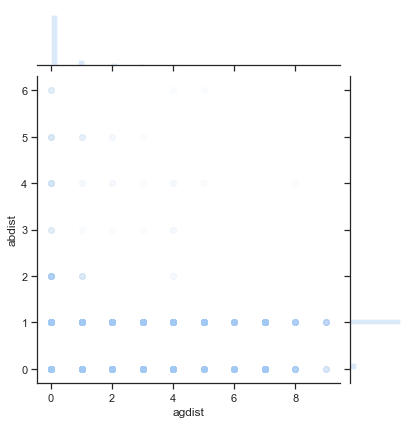

In [3]:
def neighbor_gap():
	'''
	Finds the gap between residues
	'''
	infile = 'abdb_outfiles/respair_ab_full_h.csv'
	df = pd.read_csv(infile)
	#abdf = df.xs(['distance', 'abresnum', 'name'], axis=1)
	#abdf_1 = abdf.shift(-1)
	#distance_diff = abdf.distance - abdf_1.distance
	#print(abdf.distance)	
	#print(help(df.xs))
	name_distance = df.xs(['name','agresnum','abresnum'],axis=1).values
	resnum_diffs = []
	for i in range(len(name_distance)-1):
		if name_distance[i,0] == name_distance[i+1,0] and name_distance[i,2] > 80:
			diff = np.abs(name_distance[i,1:] - name_distance[i+1,1:])
			if diff[0] < 10:
				resnum_diffs.append(diff)
	resnum_diffs = pd.DataFrame(resnum_diffs, columns=['agdist','abdist'])
	#sns.set(style='ticks', palette = 'BuGn_d')
	sns.jointplot(x='agdist', y='abdist', data=resnum_diffs, alpha=0.05)#, kind='kde')
	#view_temp()
neighbor_gap()
	

most neighbor residues are next to each other

un stuff
et_single_antigens()
et_residue_pairs()
h_counts()
et_h_epitope()
espair_exams('abdb_outfiles/respair.csv')
ositional_distance('abdb_outfiles/respair.csv')
et_residue_pairs_ab()
et_seq_pair()
et_h_epitope_ab()
ind_car()
neighbor_gap()